In [ ]:
import pandas as pd

df = pd.read_csv("/content/youtube-remove-emoji.csv")

In [ ]:
df.drop(['id','video id','author', 'author id', 'annotator notes', 'Unnamed: 0.1', 'Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
df.head()

,text,label
0,We all stand for Palestine.,Pro-Palestine
1,I am and I stand by Palestine\n\nMay God help...,Pro-Palestine
2,Maldives too,irrelevant
3,Bangladesh always support Palestine,Pro-Palestine
4,also Bahrain,irrelevant


In [ ]:
df.dropna(subset=["label"], inplace=True)

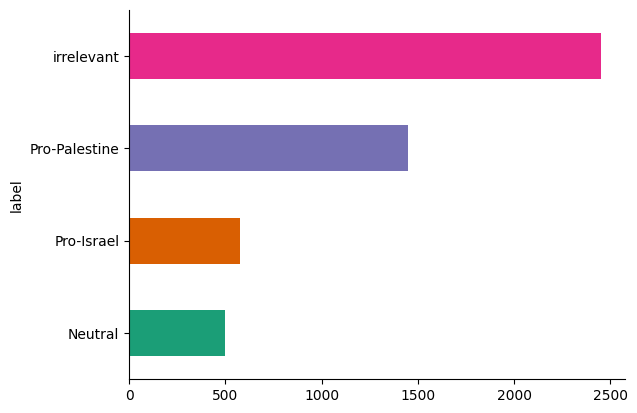

In [ ]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.shape

(4976, 2)

In [ ]:
import torch, os
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
labels = df['label'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Pro-Palestine', 'irrelevant', 'Pro-Israel', 'Neutral']

In [ ]:
NUM_LABELS= len(labels)
id2label = {id:label for id,label in enumerate(labels)}
label2id = {label:id for id,label in enumerate(labels)}

In [ ]:
print(label2id)
print(id2label)

{'Pro-Palestine': 0, 'irrelevant': 1, 'Pro-Israel': 2, 'Neutral': 3}
{0: 'Pro-Palestine', 1: 'irrelevant', 2: 'Pro-Israel', 3: 'Neutral'}


In [ ]:
temp = pd.factorize(df.label)[0]

In [ ]:
temp

array([0, 0, 1, ..., 0, 2, 1])

In [ ]:
df["label_num"]=df.label.map(lambda x: label2id[x.strip()])

In [ ]:
df.head()

,text,label,label_num
0,We all stand for Palestine.,Pro-Palestine,0
1,I am and I stand by Palestine\n\nMay God help...,Pro-Palestine,0
2,Maldives too,irrelevant,1
3,Bangladesh always support Palestine,Pro-Palestine,0
4,also Bahrain,irrelevant,1


<Axes: ylabel='count'>

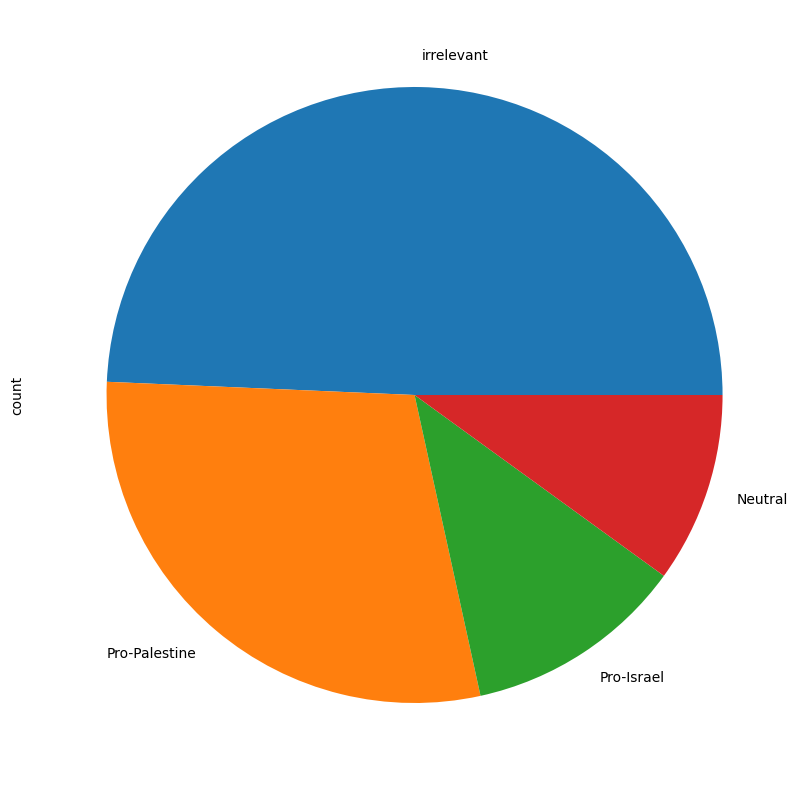

In [ ]:
df.label.value_counts().plot(kind='pie', figsize=(10,10))

In [ ]:
from transformers import BertTokenizerFast, BertForSequenceClassification

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/stance-bert-base-uncased", max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained("digitalepidemiologylab/stance-bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
SIZE= df.shape[0]

train_texts= list(df.text[:SIZE//2])

val_texts=   list(df.text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df.text[(3*SIZE)//4:])

train_labels= list(df.label_num[:SIZE//2])

val_labels=   list(df.label_num[SIZE//2:(3*SIZE)//4])

test_labels=  list(df.label_num[(3*SIZE)//4:])

In [ ]:
len(train_texts)

2488

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

(2488, 1244, 1244)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


In [ ]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.305000,1.123768,0.571543,0.292900,0.355914,0.330956
100,0.978100,0.873078,0.699357,0.463220,0.452793,0.495760
150,0.902000,0.756824,0.700161,0.428068,0.427373,0.464139
200,0.754400,0.730032,0.725080,0.525457,0.724000,0.539758
250,0.707100,0.731106,0.722669,0.602153,0.638703,0.611009
300,0.657600,0.684120,0.751608,0.613110,0.688480,0.630759
350,0.494600,0.743393,0.734727,0.630426,0.642911,0.650668
400,0.438200,0.749889,0.731511,0.634745,0.635669,0.657127
450,0.424700,0.740872,0.750000,0.632635,0.657858,0.644887


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=468, training_loss=0.7265617450078329, metrics={'train_runtime': 286.3501, 'train_samples_per_second': 26.066, 'train_steps_per_second': 1.634, 'total_flos': 1963896182636544.0, 'train_loss': 0.7265617450078329, 'epoch': 3.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df) for df in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.274436,0.916399,0.866208,0.887595,0.854486
val,0.725805,0.754019,0.634706,0.664569,0.646080
test,0.629883,0.774116,0.639810,0.645349,0.647494


In [ ]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
model_path = "Stance-Detection-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('harshit-model/tokenizer_config.json',
 'harshit-model/special_tokens_map.json',
 'harshit-model/vocab.txt',
 'harshit-model/added_tokens.json',
 'harshit-model/tokenizer.json')

NameError: name 'df' is not defined

Most watched video ID: XKXP-zX9rJo
Number of unique viewers: 32


Generating Embeddings: 100%|██████████| 2522/2522 [05:35<00:00,  7.51it/s]

Shape of first embedding: (768,)
First embedding: [0.34381765127182007, -0.08050817251205444, 0.31611114740371704, -0.6325661540031433, -0.060900237411260605]...


Top 5 most watched video IDs: ['OFZf6M_lv0Q', 'XKXP-zX9rJo', 'f9xFKrwiV_c', 'NyTA_YY42NA', 'OfV6Bq-CBJo']


,id,video id,author,author id,text,label,annotator notes,embedding
2331,UgzlUMBdBvRlrF4eccV4AaABAg,OFZf6M_lv0Q,@always-deep,UCoc1rMkZ7figX-UNZZOkFpA,They're targeting hospitals on purpose to bri...,Pro-Palestine,NaN,"[-0.6246255040168762, -0.09840894490480423, 0...."
2332,UgxwJ3Ipbl_6P0Pn2zB4AaABAg.9x7pjov_uML9x8TA7wXWtb,OFZf6M_lv0Q,@clementeen,NaN,VaucluseVanguardYoue talking utter psychopathy...,Pro-Palestine,NaN,"[0.05608952045440674, -0.32256320118904114, -0..."
2333,UgwQecuPJBVS-D6cfER4AaABAg,OFZf6M_lv0Q,@nimofarah168,UCfro3SIXzactUVwhOSkcPkw,is this what Palestine people are facing so ma...,Pro-Palestine,NaN,"[0.6580413579940796, 0.22902774810791016, -0.1..."
2334,Ugx62480m0VKqqeo73l4AaABAg,OFZf6M_lv0Q,@ibniloveitmushtaq6925,UCp5RZwXicJUydBx1LEtxQZw,This is absolutely inhumane.... May ALLAH SWT ...,Neutral,NaN,"[0.5031351447105408, 0.7489227652549744, 0.361..."
2335,UgzvKIITmoBYRULuBKR4AaABAg,OFZf6M_lv0Q,@sheemazikra9341,UCaBW-vLhu2r-YhgjJHOh6hw,shame on you,Pro-Palestine,NaN,"[-0.974638044834137, -0.21236950159072876, 0.0..."


<ipython-input-158-1d255abb06ee>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['embedding'] = df_vid['embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)


Graph has been saved as 'similarity_graph.png'
Number of nodes: 33
Number of edges: 57
Node distribution:
label
Pro-Palestine    22
Neutral           8
Pro-Israel        3
Name: count, dtype: int64


In [ ]:
df

,id,video id,author,author id,text,label,annotator notes,embedding
0,UgzJMmyfh-V9DdspcKN4AaABAg,M7jj9c4pzIA,@IbrahimKhalil-nq4ee,UCFzHoqYnhDk5plzEXlKiKSA,We all stand for Palestine.,Pro-Palestine,NaN,"[0.34381765127182007, -0.08050817251205444, 0...."
1,UgxSPspi64LsuKtOygR4AaABAg,M7jj9c4pzIA,@BAJI_AMVS_14790,UCE1aLbKG8Hb-P477PbS3QEA,I am and I stand by Palestine\n\nMay God help...,Pro-Palestine,NaN,"[0.4935488700866699, 0.014816734939813614, -0...."
2,Ugxg1Tc9rCA5eZH4Mxx4AaABAg,M7jj9c4pzIA,@humairakhanum9236,UCWqEP87w-XVWvAvbATjbbtQ,Bangladesh always support Palestine,Pro-Palestine,NaN,"[0.5936932563781738, -0.2137385606765747, -0.3..."
3,UgwChYIgtkQBRUSjkBp4AaABAg,M7jj9c4pzIA,@amrutagaikwad8400,UCsijeyXEpT66rt6Zo6cL-sw,If whole world supports Israel then also Israe...,Pro-Israel,NaN,"[-0.2543106973171234, -0.24032142758369446, 0...."
4,UgwtX5qqxH71KffGSpN4AaABAg,M7jj9c4pzIA,@bhuiyantushar7384,UCJdl6ArZby8mgj9DQ9K1L2w,"Only the,counrry,you should support is palestine",Pro-Palestine,NaN,"[0.30078762769699097, -0.06325650960206985, -0..."
...,...,...,...,...,...,...,...,...
2517,UgxcWzoCZkIqC2JQwTJ4AaABAg.9wfSPsfPSay9wj6OTMv--m,mNZjKgJGakA,@lostbofromafrica8668,NaN,Traumatized,Neutral,NaN,"[-0.7988587021827698, -0.34796327352523804, 0...."
2518,UgyaWVUcspQBAm9SAxh4AaABAg.9wg8J6AmK3y9wgBS_oP7E1,mNZjKgJGakA,@kapilmaurya8855,NaN,gtgaminghq1733 why you people are only talking...,Pro-Palestine,NaN,"[0.34427157044410706, -0.03211380913853645, -0..."
2519,UgyR3p_akBUyEeB_I5F4AaABAg,mNZjKgJGakA,@yahruleyahsharahla3298,UCpZo_iKY_iNXPj9TzdyxYDA,Americans need to go there and stand in these ...,Pro-Palestine,NaN,"[0.43116581439971924, 0.189890518784523, -0.25..."
2520,Ugy_Dg_mqt6WqZnRUE54AaABAg,mNZjKgJGakA,@CircaBEFORE,UC3hNeGPkxgqHe7v_kwvwqBg,Absolutely evil. My heart is with the people o...,Pro-Palestine,NaN,"[0.4501556158065796, 0.26286089420318604, -0.1..."


,id,video id,author,author id,text,label,annotator notes,embedding


OFZf6M_lv0Q


<ipython-input-160-a2e3cd2742fd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['embedding'] = df_vid['embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)


Graph has been saved as 'similarity_graph.png'
Number of nodes: 33
Number of edges: 57
Node distribution:
label
Pro-Palestine    22
Neutral           8
Pro-Israel        3
Name: count, dtype: int64
XKXP-zX9rJo


<ipython-input-160-a2e3cd2742fd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['embedding'] = df_vid['embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)


Graph has been saved as 'similarity_graph.png'
Number of nodes: 32
Number of edges: 211
Node distribution:
label
Pro-Palestine    25
Pro-Israel        4
Neutral           3
Name: count, dtype: int64
f9xFKrwiV_c


<ipython-input-160-a2e3cd2742fd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['embedding'] = df_vid['embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)


Graph has been saved as 'similarity_graph.png'
Number of nodes: 27
Number of edges: 75
Node distribution:
label
Pro-Palestine    14
Neutral           7
Pro-Israel        6
Name: count, dtype: int64
NyTA_YY42NA


<ipython-input-160-a2e3cd2742fd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['embedding'] = df_vid['embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)


Graph has been saved as 'similarity_graph.png'
Number of nodes: 26
Number of edges: 113
Node distribution:
label
Pro-Palestine    13
Pro-Israel       11
Neutral           2
Name: count, dtype: int64
OfV6Bq-CBJo


<ipython-input-160-a2e3cd2742fd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['embedding'] = df_vid['embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)


Graph has been saved as 'similarity_graph.png'
Number of nodes: 25
Number of edges: 81
Node distribution:
label
Pro-Palestine    21
Pro-Israel        2
Neutral           2
Name: count, dtype: int64


OFZf6M_lv0Q


<ipython-input-161-92a64e8312fe>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['embedding'] = df_vid['embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)


Graph for video OFZf6M_lv0Q at threshold 0.3 has been saved.
Graph for video OFZf6M_lv0Q at threshold 0.5 has been saved.
Graph for video OFZf6M_lv0Q at threshold 0.7 has been saved.
Graph for video OFZf6M_lv0Q at threshold 0.9 has been saved.
Number of nodes for video OFZf6M_lv0Q: 33
Number of edges for video OFZf6M_lv0Q: 11
Node distribution:
label
Pro-Palestine    22
Neutral           8
Pro-Israel        3
Name: count, dtype: int64
XKXP-zX9rJo


<ipython-input-161-92a64e8312fe>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['embedding'] = df_vid['embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)


Graph for video XKXP-zX9rJo at threshold 0.3 has been saved.
Graph for video XKXP-zX9rJo at threshold 0.5 has been saved.
Graph for video XKXP-zX9rJo at threshold 0.7 has been saved.
Graph for video XKXP-zX9rJo at threshold 0.9 has been saved.
Number of nodes for video XKXP-zX9rJo: 32
Number of edges for video XKXP-zX9rJo: 99
Node distribution:
label
Pro-Palestine    25
Pro-Israel        4
Neutral           3
Name: count, dtype: int64
f9xFKrwiV_c


<ipython-input-161-92a64e8312fe>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['embedding'] = df_vid['embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)


Graph for video f9xFKrwiV_c at threshold 0.3 has been saved.
Graph for video f9xFKrwiV_c at threshold 0.5 has been saved.
Graph for video f9xFKrwiV_c at threshold 0.7 has been saved.
Graph for video f9xFKrwiV_c at threshold 0.9 has been saved.
Number of nodes for video f9xFKrwiV_c: 27
Number of edges for video f9xFKrwiV_c: 42
Node distribution:
label
Pro-Palestine    14
Neutral           7
Pro-Israel        6
Name: count, dtype: int64
NyTA_YY42NA


<ipython-input-161-92a64e8312fe>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['embedding'] = df_vid['embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)


Graph for video NyTA_YY42NA at threshold 0.3 has been saved.
Graph for video NyTA_YY42NA at threshold 0.5 has been saved.
Graph for video NyTA_YY42NA at threshold 0.7 has been saved.
Graph for video NyTA_YY42NA at threshold 0.9 has been saved.
Number of nodes for video NyTA_YY42NA: 26
Number of edges for video NyTA_YY42NA: 33
Node distribution:
label
Pro-Palestine    13
Pro-Israel       11
Neutral           2
Name: count, dtype: int64
OfV6Bq-CBJo


<ipython-input-161-92a64e8312fe>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['embedding'] = df_vid['embedding'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)


Graph for video OfV6Bq-CBJo at threshold 0.3 has been saved.
Graph for video OfV6Bq-CBJo at threshold 0.5 has been saved.
Graph for video OfV6Bq-CBJo at threshold 0.7 has been saved.
Graph for video OfV6Bq-CBJo at threshold 0.9 has been saved.
Number of nodes for video OfV6Bq-CBJo: 25
Number of edges for video OfV6Bq-CBJo: 21
Node distribution:
label
Pro-Palestine    21
Pro-Israel        2
Neutral           2
Name: count, dtype: int64
